In [35]:
import kaggle as kg
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.environ["USERNAME"] = "aimlrl"
os.environ["KEY"] = "f9fcb3d12c2c4845724a50f0cdeab5ea"

In [3]:
kg.api.authenticate()

In [4]:
kg.api.dataset_download_files(dataset="ehtishamsadiq/uncleaned-laptop-price-dataset",
                              path="./dataset",unzip=True)

Dataset URL: https://www.kaggle.com/datasets/ehtishamsadiq/uncleaned-laptop-price-dataset


In [5]:
data = pd.read_csv("dataset/laptopData.csv")

In [6]:
data.head()

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1.0,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2.0,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3.0,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [7]:
data.isna().sum()

Unnamed: 0          30
Company             30
TypeName            30
Inches              30
ScreenResolution    30
Cpu                 30
Ram                 30
Memory              30
Gpu                 30
OpSys               30
Weight              30
Price               30
dtype: int64

In [8]:
data.dropna(axis=0,inplace=True)

In [9]:
data.isna().sum()

Unnamed: 0          0
Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price               0
dtype: int64

In [10]:
data.drop(labels=data.columns[0],axis=1,inplace=True)

In [11]:
def label_encode_column(column_name):

    data[column_name].unique()

    d = dict()
    for value in data[column_name].unique():
        d[value] = data[data[column_name] == value][data.columns[-1]].mean()

    input_target_df = pd.DataFrame(data={column_name:d.keys(),"Mean Price":d.values()})
    input_target_df.sort_values(by="Mean Price",inplace=True)
    input_target_df.reset_index(inplace=True,drop=True)

    data[column_name] = data[column_name].replace(to_replace=list(input_target_df[column_name]),
                              value=list(input_target_df.index)).infer_objects(copy=False)

In [12]:
categorical_columns = list(data.columns[0:2]) + list(data.columns[3:5]) + list(data.columns[6:9])

In [13]:
categorical_columns

['Company', 'TypeName', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu', 'OpSys']

In [14]:
for column_name in categorical_columns:

    label_encode_column(column_name)

/tmp/ipykernel_32247/930716832.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[column_name] = data[column_name].replace(to_replace=list(input_target_df[column_name]),


In [ ]:
data

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,13,3,13.3,26,85,8GB,14,80,8,1.37kg,71378.6832
1,13,3,13.3,13,64,8GB,13,45,8,1.34kg,47895.5232
2,5,1,15.6,15,58,8GB,21,54,2,1.86kg,30636.0000
3,13,3,15.4,36,111,16GB,31,95,8,1.83kg,135195.3360
4,13,3,13.3,26,99,8GB,21,84,8,1.37kg,96095.8080
...,...,...,...,...,...,...,...,...,...,...,...
1298,6,2,14,16,77,4GB,14,47,4,1.8kg,33992.6400
1299,6,2,13.3,22,77,16GB,31,47,4,1.3kg,79866.7200
1300,6,1,14,4,16,2GB,6,6,4,1.5kg,12201.1200
1301,5,1,15.6,4,77,6GB,12,32,4,2.19kg,40705.9200


In [16]:
data["Ram"] = data["Ram"].apply(lambda x: float(x.split("GB")[0]))

In [17]:
data

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,13,3,13.3,26,85,8.0,14,80,8,1.37kg,71378.6832
1,13,3,13.3,13,64,8.0,13,45,8,1.34kg,47895.5232
2,5,1,15.6,15,58,8.0,21,54,2,1.86kg,30636.0000
3,13,3,15.4,36,111,16.0,31,95,8,1.83kg,135195.3360
4,13,3,13.3,26,99,8.0,21,84,8,1.37kg,96095.8080
...,...,...,...,...,...,...,...,...,...,...,...
1298,6,2,14,16,77,4.0,14,47,4,1.8kg,33992.6400
1299,6,2,13.3,22,77,16.0,31,47,4,1.3kg,79866.7200
1300,6,1,14,4,16,2.0,6,6,4,1.5kg,12201.1200
1301,5,1,15.6,4,77,6.0,12,32,4,2.19kg,40705.9200


(array([397., 280., 125., 111.,  94.,  79.,  68.,  38.,  49.,  32.]),
 array([  0. ,  18.8,  37.6,  56.4,  75.2,  94. , 112.8, 131.6, 150.4,
        169.2, 188. ]),
 <BarContainer object of 10 artists>)

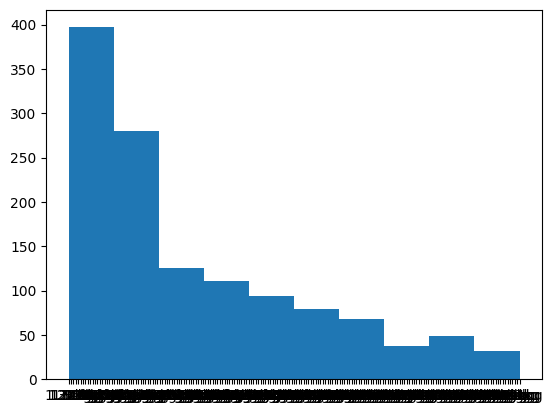

In [18]:
plt.hist(data["Weight"])

In [19]:
data["Weight"].value_counts().index[0]

'2.2kg'

In [20]:
data["Weight"].replace(to_replace="?",value=data["Weight"].value_counts().index[0],
                       inplace=True)

/tmp/ipykernel_32247/322094499.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Weight"].replace(to_replace="?",value=data["Weight"].value_counts().index[0],


In [22]:
data["Weight"] = data["Weight"].apply(lambda x: float(x.split("kg")[0]))

In [23]:
data

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,13,3,13.3,26,85,8.0,14,80,8,1.37,71378.6832
1,13,3,13.3,13,64,8.0,13,45,8,1.34,47895.5232
2,5,1,15.6,15,58,8.0,21,54,2,1.86,30636.0000
3,13,3,15.4,36,111,16.0,31,95,8,1.83,135195.3360
4,13,3,13.3,26,99,8.0,21,84,8,1.37,96095.8080
...,...,...,...,...,...,...,...,...,...,...,...
1298,6,2,14,16,77,4.0,14,47,4,1.80,33992.6400
1299,6,2,13.3,22,77,16.0,31,47,4,1.30,79866.7200
1300,6,1,14,4,16,2.0,6,6,4,1.50,12201.1200
1301,5,1,15.6,4,77,6.0,12,32,4,2.19,40705.9200


In [26]:
data["Inches"].replace(to_replace="?",value=data["Inches"].value_counts().index[0],
                       inplace=True)

In [33]:
data["Inches"] = data["Inches"].astype("float64")

In [39]:
data.drop_duplicates(inplace=True,ignore_index=True)

In [40]:
data.shape

(1244, 11)

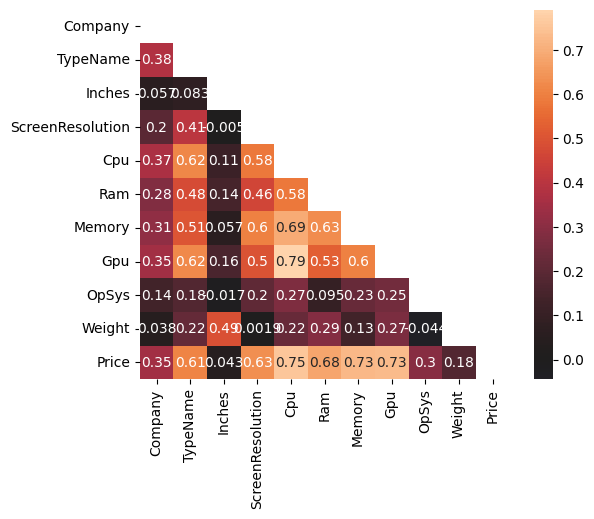

In [41]:
data_corr = data.corr()
upper_traingle_mask = np.triu(np.ones_like(data_corr,dtype=bool))
sns.heatmap(data=data_corr,center=0,annot=True,square=True,xticklabels=True,yticklabels=True,mask=upper_traingle_mask)
plt.show()